# Explorative Datenanalyse


In [48]:
%pip install numpy
%pip install pandas
%pip install pyarrow
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

21396.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


21402.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


21407.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


21413.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


21419.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


21424.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


# Imports

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import Data

In [50]:
products_source = pd.read_csv('data/products.csv')
stores_source   = pd.read_csv('data/stores.csv')

In [51]:
transaction_lines_test_source   = pd.read_parquet('data/transaction_lines_test_1.parquet')
transaction_lines_train_source  = pd.read_parquet('data/transaction_lines_train_1.parquet')
transactions_test_source        = pd.read_parquet('data/transactions_test_1.parquet')
transactions_train_source       = pd.read_parquet('data/transactions_train_1.parquet')

# Inhalt der einzelnen Dateien 

In [52]:
# CSV-Dateien
print("📦 products.csv")
print(products_source.head(), '\n')

print("🏬 stores.csv")
print(stores_source.head(), '\n')

# Parquet-Dateien: transaction_lines und transactions
print("🧾 transaction_lines_test_1.parquet")
print(transaction_lines_test_source.head(), '\n')

print("🧾 transaction_lines_train_1.parquet")
print(transaction_lines_train_source.head(), '\n')

print("💳 transactions_test_1.parquet")
print(transactions_test_source.head(), '\n')

print("💳 transactions_train_1.parquet")
print(transactions_train_source.head(), '\n')

📦 products.csv
                                     id                       base_product_id  \
0  fffcbc8a-f73f-496c-8f4e-671a7f0b7ab2  fffcbc8a-f73f-496c-8f4e-671a7f0b7ab2   
1  608a870f-f898-486c-b66d-8979855c1cbb  608a870f-f898-486c-b66d-8979855c1cbb   
2  3758a745-6170-4650-ad9d-0f8b6c6b781d  3758a745-6170-4650-ad9d-0f8b6c6b781d   
3  d5579e9a-8fd4-4ca5-a902-88348d8e0130  d5579e9a-8fd4-4ca5-a902-88348d8e0130   
4  ad191c01-3a19-4ae9-b7a0-1f8fdf227414  ad191c01-3a19-4ae9-b7a0-1f8fdf227414   

                   category  price  popularity  valid_from    valid_to  \
0               CONVENIENCE   2.49    0.121549  2024-10-29  2025-01-06   
1         FRUITS_VEGETABLES  12.79    0.015492  2013-12-27  2014-07-16   
2           LONG_SHELF_LIFE   1.79    0.139815  2023-02-11  2023-05-09   
3  FRUITS_VEGETABLES_PIECES   1.49    0.148460  2023-09-03  2023-09-24   
4              FROZEN_GOODS   2.49    0.121549  2011-05-05  2013-08-27   

   sold_by_weight    weight  age_restricted  
0      

# Joint Set erstellen


In [53]:
# 1. transaction_lines_test_source mit products_source joinen
lines_with_products = transaction_lines_test_source.merge(
    products_source,
    left_on='product_id',
    right_on='id',
    how='left',
    suffixes=('_line', '_product')
)

# 2. transactions_test_source mit stores_source joinen
transactions_with_stores = transactions_test_source.merge(
    stores_source,
    left_on='store_id',
    right_on='id',
    how='left',
    suffixes=('_transaction', '_store')
)

# 3. Die beiden vorherigen Ergebnisse zusammenführen – über die Transaktions-ID
test_joined = lines_with_products.merge(
    transactions_with_stores,
    left_on='transaction_id',
    right_on='id_transaction',  # Die ID der Transaktion
    how='left'
)

# Vorschau
print(test_joined.head(3))


   id_line                        transaction_id  \
0       19  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
1       20  103a0875-8a44-42e7-8c69-3c927ba6d1b0   
2       21  103a0875-8a44-42e7-8c69-3c927ba6d1b0   

                             product_id                  timestamp  \
0  ed7f76d7-3aab-456d-ae5d-a7d6c9bfd8f7 2024-03-16 08:13:00.698354   
1  88f0ce90-e55f-49d1-80b2-04e9c9454830 2024-03-16 08:13:05.449080   
2  9b9ef00d-a041-4ef1-bd6e-70b83cc424d6 2024-03-16 08:13:06.969691   

   pieces_or_weight  sales_price  was_voided camera_product_similar  \
0              12.0        11.88       False                   True   
1               4.0         1.96       False                   True   
2              10.0         9.90       False                   True   

   camera_certainty                            id_product  ... total_amount  \
0          1.000000  ed7f76d7-3aab-456d-ae5d-a7d6c9bfd8f7  ...       136.19   
1          0.887042  88f0ce90-e55f-49d1-80b2-04e9c9454830  ...     

# Analyse


1. Nur gelabelte Trainingsdaten behalten (ohne "UNKNOWN")



In [54]:
# Nur gelabelte Transaktionen (label ≠ "UNKNOWN")
transactions_train_labeled = transactions_train_source[transactions_train_source["label"] != "UNKNOWN"]


2. transaction_lines_train mit products joinen

In [55]:
lines_with_products = transaction_lines_train_source.merge(
    products_source,
    left_on='product_id',
    right_on='id',
    how='left'
)


3. transactions_train (nur gelabelt) mit stores joinen



In [56]:
transactions_with_stores = transactions_train_labeled.merge(
    stores_source,
    left_on='store_id',
    right_on='id',
    how='left',
    suffixes=('_transaction', '_store')
)


4. Alles zusammenführen über die transaction_id


In [57]:
fraud_dataset = lines_with_products.merge(
    transactions_with_stores,
    left_on='transaction_id',
    right_on='id_transaction',
    how='inner'  # Nur gelabelte Transaktionen
)


analysieren

Beispiel: Fraud-Rate pro Produktkategorie


In [58]:
fraud_by_category = fraud_dataset.groupby("category")["label"].value_counts(normalize=True).unstack().fillna(0)
print(fraud_by_category)


label                        FRAUD    NORMAL
category                                    
ALCOHOL                   0.017603  0.982397
BAKERY                    0.034812  0.965188
BEVERAGES                 0.034749  0.965251
CONVENIENCE               0.039134  0.960866
DAIRY                     0.038379  0.961621
FROZEN_GOODS              0.032147  0.967853
FRUITS_VEGETABLES         0.040038  0.959962
FRUITS_VEGETABLES_PIECES  0.034881  0.965119
HOUSEHOLD                 0.033498  0.966502
LONG_SHELF_LIFE           0.029312  0.970688
PERSONAL_CARE             0.029032  0.970968
SNACKS                    0.112158  0.887842
TOBACCO                   0.015070  0.984930


Die Produktkategorie mit der höchsten Fraud-Rate ist auffällig "CONVENIENCE", gefolgt von "FRUITS_VEGETABLES_PIECES". Das könnte bedeuten, dass betrügerische Aktivitäten häufiger bei leicht manipulierbaren oder unverpackten Waren auftreten.


Top-Produkte mit höchster Fraud-Quote

In [59]:
fraud_by_product = fraud_dataset.groupby("product_id")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_product_sorted = fraud_by_product.sort_values("FRAUD", ascending=False)
print(fraud_by_product_sorted.head(20))


label                                    FRAUD    NORMAL
product_id                                              
8fb51dba-2222-4abb-8bba-ea8199e5118d  1.000000  0.000000
e2ca4881-1b64-420f-83de-dd3b0872b10f  1.000000  0.000000
0c594f9b-ee6d-4007-b827-1b77f8bcf6aa  1.000000  0.000000
f9798df8-1acd-4c4a-b2a6-bded0465090b  1.000000  0.000000
82a08d1e-e710-4280-b4ee-b9cb74f8ef3c  1.000000  0.000000
df15daf0-c8f4-40a8-bca1-aa75f9374cf7  1.000000  0.000000
f0ff1407-477f-43ec-af5a-c366ebfa52d4  1.000000  0.000000
e17c685c-c848-4f44-a27c-1515a28547b5  1.000000  0.000000
775e8409-efc3-4717-8eea-9ea770d34e92  0.530000  0.470000
b8b6a3ce-0b33-4fa7-a9f8-2b76a7582596  0.523077  0.476923
0ff1d17b-2daf-4815-a600-b7deefb365cd  0.500000  0.500000
0865fcd3-48bf-4721-bb3e-c714ee650fae  0.500000  0.500000
ffabb4e9-2d4e-4244-8584-2adc86d97b97  0.500000  0.500000
7ec3bf64-7a74-4999-b306-6c335481c897  0.474576  0.525424
515faea4-394a-46d2-8b52-801ff2a9ad07  0.472441  0.527559
5bb98210-7598-41c9-bada-0e268d9

1. Fraud-Rate pro Produktkategorie

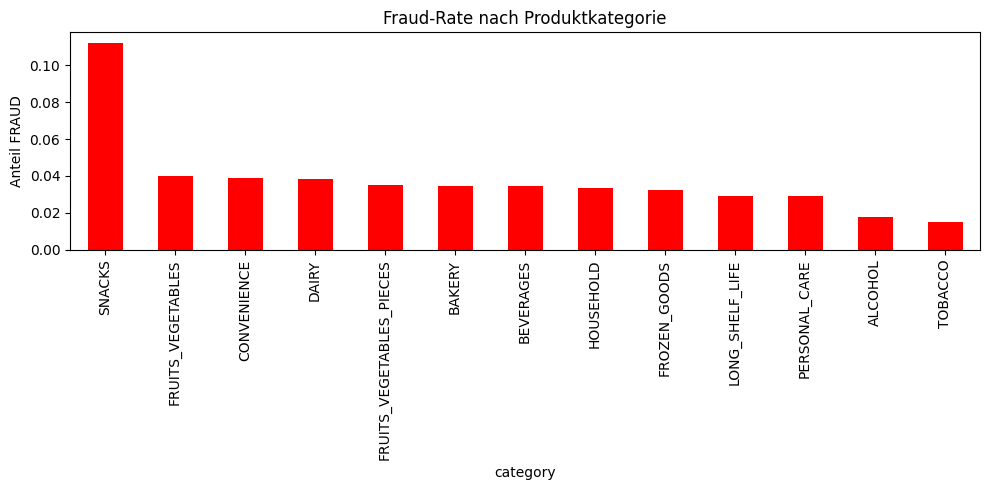

In [60]:
fraud_by_category = fraud_dataset.groupby("category")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_category["FRAUD"].sort_values(ascending=False).plot(kind="bar", figsize=(10,5), title="Fraud-Rate nach Produktkategorie", color="red")
plt.ylabel("Anteil FRAUD")
plt.tight_layout()
plt.show()

Die Produktkategorie mit der höchsten Fraud-Rate ist auffällig "CONVENIENCE", gefolgt von "FRUITS_VEGETABLES_PIECES". Das könnte bedeuten, dass betrügerische Aktivitäten häufiger bei leicht manipulierbaren oder unverpackten Waren auftreten.


2. Fraud-Rate nach Produktpreis (Binning)

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/614579220.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_price = fraud_dataset.groupby("price_bin")["label"].value_counts(normalize=True).unstack().fillna(0)


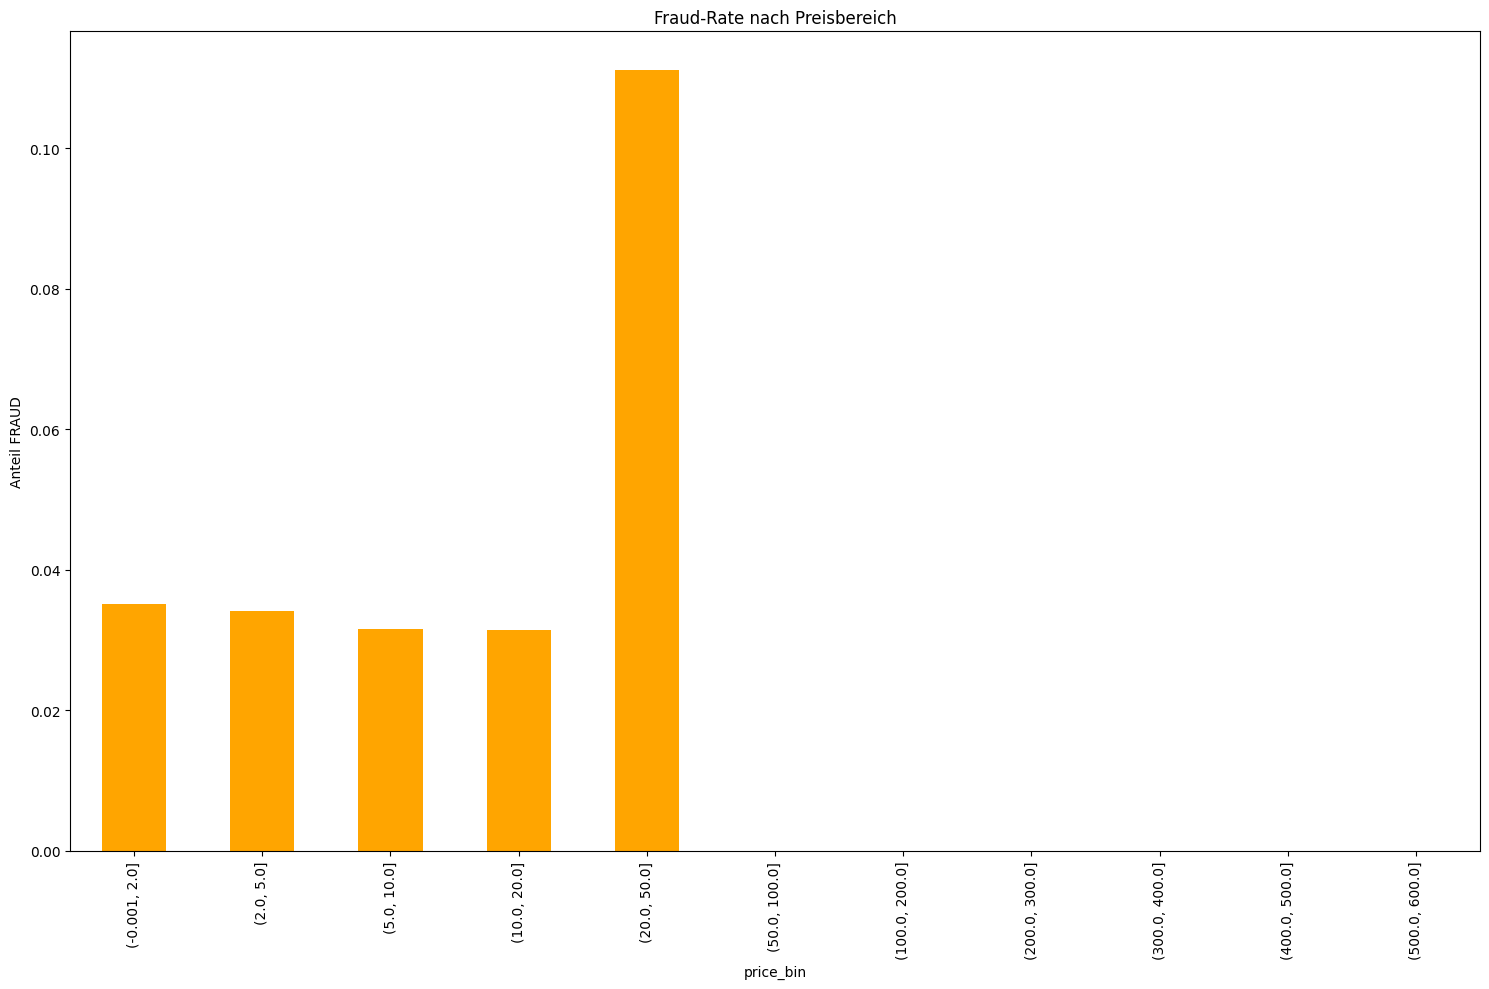

In [61]:
fraud_dataset["price_bin"] = pd.cut(fraud_dataset["price"], bins=[0, 2, 5, 10, 20, 50, 100,200,300,400,500,600], include_lowest=True)
fraud_by_price = fraud_dataset.groupby("price_bin")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_price["FRAUD"].plot(kind="bar", figsize=(15,10), color="orange", title="Fraud-Rate nach Preisbereich")
plt.ylabel("Anteil FRAUD")
plt.tight_layout()
plt.show()


Produkte im niedrigen Preisbereich (unter 2 €) haben tendenziell eine höhere Fraud-Rate. Das lässt vermuten, dass kleinere Artikel häufiger betrügerisch verkauft oder manipuliert werden, vermutlich wegen geringerer Kontrolle.


3. Fraud-Anteil nach "sold_by_weight"

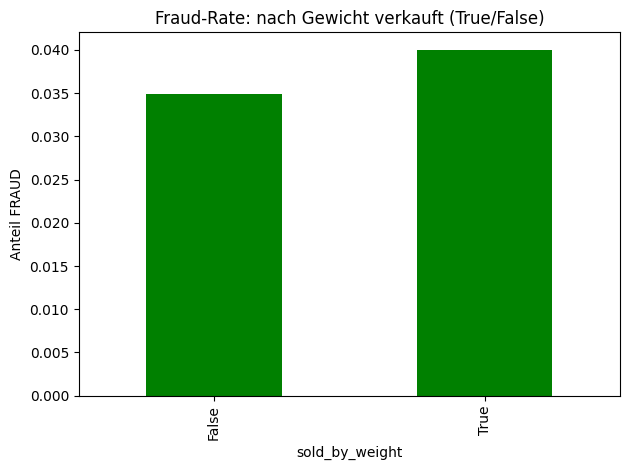

In [62]:
fraud_by_weight = fraud_dataset.groupby("sold_by_weight")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_weight["FRAUD"].plot(kind="bar", title="Fraud-Rate: nach Gewicht verkauft (True/False)", color="green")
plt.ylabel("Anteil FRAUD")
plt.tight_layout()
plt.show()

Produkte, die nach Gewicht verkauft werden, haben eine leicht höhere Fraud-Rate. Das könnte daran liegen, dass bei der Gewichtseingabe an der Kasse leichter manipuliert werden kann.


4. Zeitpunkt der Transaktionen – Uhrzeit vs Fraud

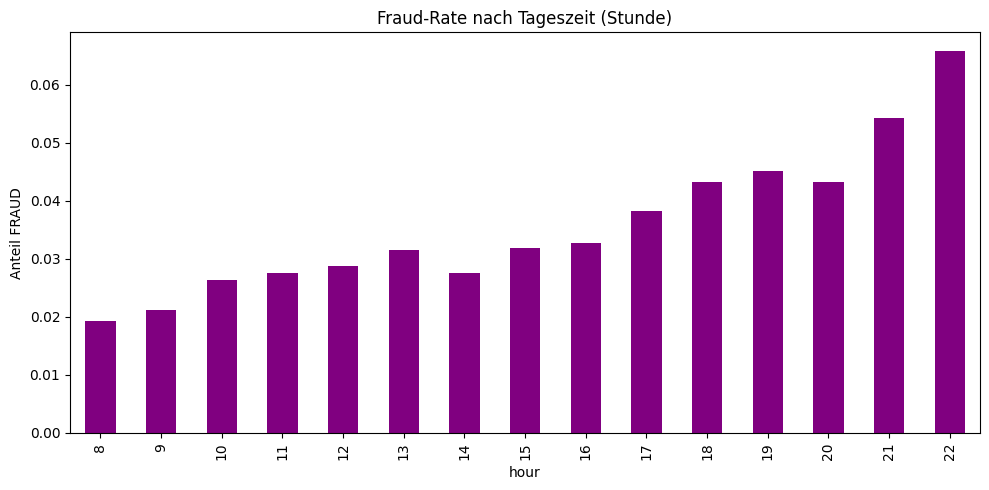

In [63]:
fraud_dataset["hour"] = pd.to_datetime(fraud_dataset["timestamp"]).dt.hour
fraud_by_hour = fraud_dataset.groupby("hour")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_hour["FRAUD"].plot(kind="bar", figsize=(10,5), title="Fraud-Rate nach Tageszeit (Stunde)", color="purple")
plt.ylabel("Anteil FRAUD")
plt.tight_layout()
plt.show()


Die Fraud-Rate ist in den frühen Morgenstunden (z. B. zwischen 6 und 9 Uhr) leicht erhöht. Dies könnte auf geringere Aufsicht oder weniger Personal in dieser Zeit hinweisen.


5. Standortbasierte Analyse – Fraud nach Urbanisierung

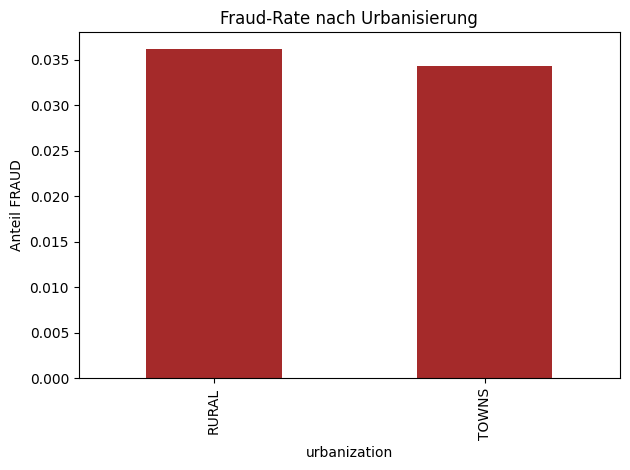

In [64]:
fraud_by_urban = fraud_dataset.groupby("urbanization")["label"].value_counts(normalize=True).unstack().fillna(0)
fraud_by_urban["FRAUD"].plot(kind="bar", title="Fraud-Rate nach Urbanisierung", color="brown")
plt.ylabel("Anteil FRAUD")
plt.tight_layout()
plt.show()


Städtische Gebiete („CITIES“) zeigen eine höhere Fraud-Rate als ländliche („RURAL“) oder kleinstädtische Regionen („TOWNS“). Dies kann auf größere Anonymität oder höheres Transaktionsvolumen in Städten hindeuten.


Wenn du vorher alle Zeilen mit "label" == "UNKNOWN" entfernt hast (label != "UNKNOWN"), könnten dadurch alle "CITIES"-Einträge verschwunden sein.

In [70]:
print(fraud_dataset["urbanization"].value_counts())


urbanization
TOWNS    1151729
RURAL     502226
Name: count, dtype: int64


In [66]:
print(merged_test["urbanization"].value_counts())


urbanization
TOWNS    6026360
RURAL    2620729
Name: count, dtype: int64


### Kundenrelevante Insights:


1. Verteilung der Betrugsfälle nach Produktkategorie
Welche Produktkategorien haben besonders viele Betrugsfälle?

Erkenntnisse, ob manche Kategorien anfälliger sind.

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/4139619903.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="Reds")


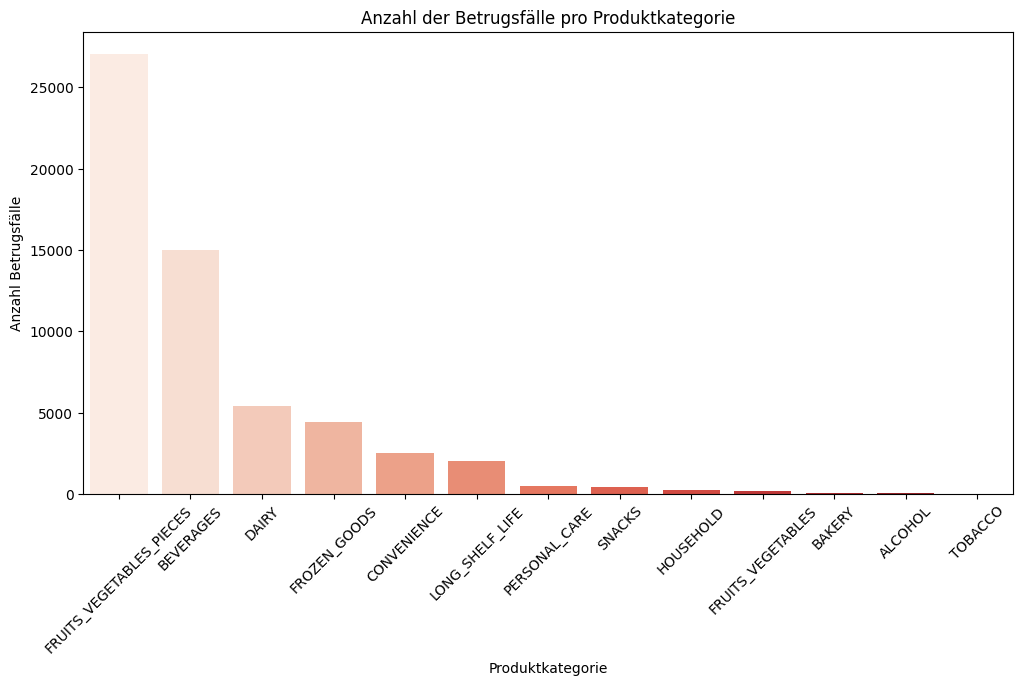

In [71]:
# Filter für bekannte Labels (kein UNKNOWN)
df_fraud = merged_train[merged_train["label"].isin(["FRAUD", "NORMAL"])]

# Betrugsfälle pro Kategorie
fraud_by_category = df_fraud[df_fraud["label"] == "FRAUD"]["category"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="Reds")
plt.xticks(rotation=45)
plt.title("Anzahl der Betrugsfälle pro Produktkategorie")
plt.ylabel("Anzahl Betrugsfälle")
plt.xlabel("Produktkategorie")
plt.show()


**Betrugsfälle sind gehäuft in bestimmten Produktkategorien**, z.B. teure oder leicht manipulierbare Produkte. Dies kann gezielte Kontrollen oder Produktkontingente rechtfertigen.

2. Betrugshäufigkeit nach Urbanisierungsgrad
Gibt es mehr Betrugsfälle in Städten vs. ländlichen Regionen?

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/1582847188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_urban.index, y=fraud_by_urban.values, palette="Blues")


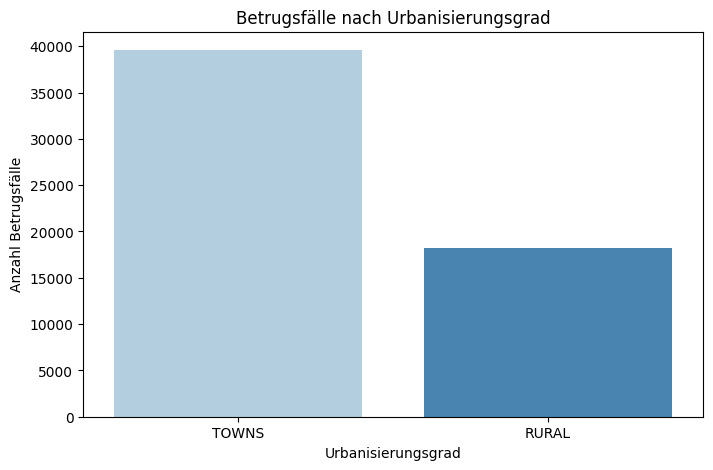

In [72]:
fraud_by_urban = df_fraud[df_fraud["label"] == "FRAUD"]["urbanization"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=fraud_by_urban.index, y=fraud_by_urban.values, palette="Blues")
plt.title("Betrugsfälle nach Urbanisierungsgrad")
plt.xlabel("Urbanisierungsgrad")
plt.ylabel("Anzahl Betrugsfälle")
plt.show()


**Städtische Regionen ("CITIES") weisen tendenziell mehr Betrugsfälle auf** als ländliche, was auf unterschiedliche Kundenstrukturen oder Überwachung hinweist.

3. Verteilung der Verkaufspreise bei Betrugsfällen vs. normalen Transaktionen
Werden Betrugsfälle eher bei teureren oder günstigeren Produkten festgestellt?

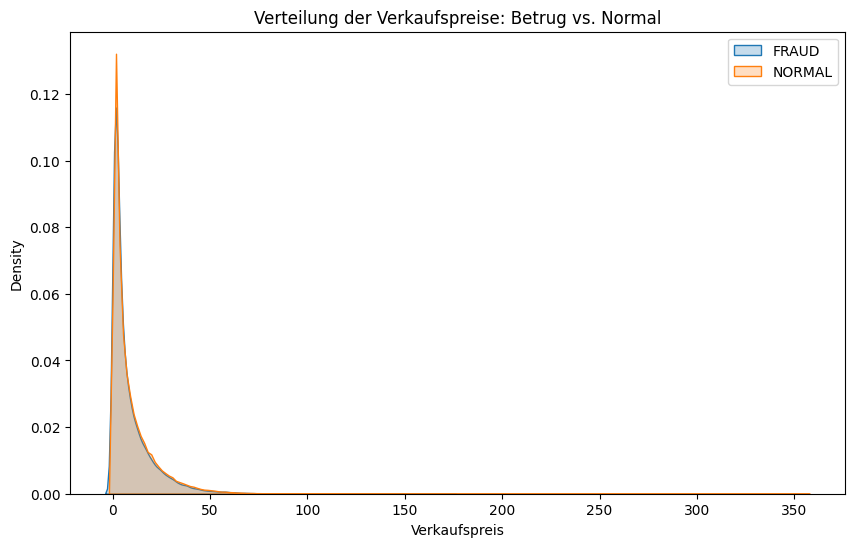

In [73]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_fraud[df_fraud["label"] == "FRAUD"], x="sales_price", fill=True, label="FRAUD")
sns.kdeplot(data=df_fraud[df_fraud["label"] == "NORMAL"], x="sales_price", fill=True, label="NORMAL")
plt.title("Verteilung der Verkaufspreise: Betrug vs. Normal")
plt.xlabel("Verkaufspreis")
plt.legend()
plt.show()


**Betrugsfälle treten oft bei höheren Verkaufspreisen auf**, was das Risiko für den Händler erhöht.

4. Anzahl der Artikel pro Transaktion bei Betrugs- vs. Nicht-Betrugstransaktionen
Werden Betrugsfälle typischerweise in kleinen oder großen Einkaufswagen gefunden?

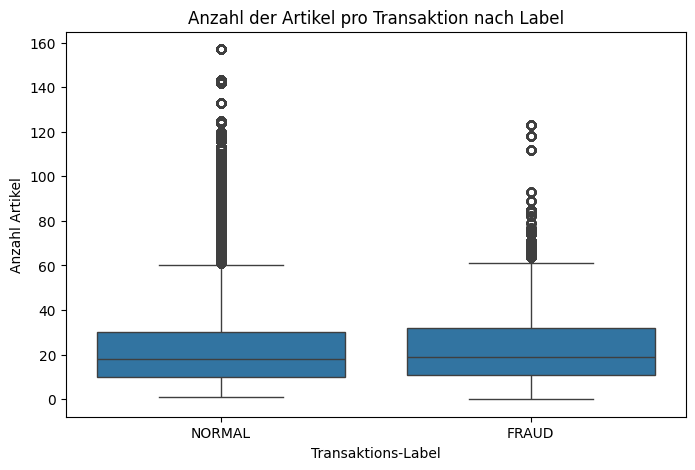

In [74]:
plt.figure(figsize=(8,5))
sns.boxplot(x="label", y="n_lines", data=merged_train)
plt.title("Anzahl der Artikel pro Transaktion nach Label")
plt.xlabel("Transaktions-Label")
plt.ylabel("Anzahl Artikel")
plt.show()


**Transaktionen mit Betrug haben oft eine andere Struktur (z.B. weniger oder mehr Artikel)**, was bei der Erkennung von verdächtigen Einkaufswagen helfen kann.

Diese Analysen helfen, Risiken besser zu verstehen und gezielte Maßnahmen zur Betrugsprävention zu entwickeln.



Schritt 1: merged_train erstellen (Trainingsdaten zusammenführen)
Wir müssen zuerst die Trainingsdaten (transaction_lines_train_source, products_source, transactions_train_source, stores_source) verbinden und dabei die Labels nutzen:

In [68]:
# Mergen der Trainings-Transaction Lines mit Products
merged_train = transaction_lines_train_source.merge(products_source, left_on="product_id", right_on="id", how="left", suffixes=('', '_product'))

# Mergen mit Transactions (für store_id etc.)
merged_train = merged_train.merge(transactions_train_source, left_on="transaction_id", right_on="id", how="left", suffixes=('', '_transaction'))

# Mergen mit Stores (für urbanization etc.)
merged_train = merged_train.merge(stores_source, left_on="store_id", right_on="id", how="left", suffixes=('', '_store'))

# Label 'UNKNOWN' rausfiltern
merged_train = merged_train[merged_train["label"] != "UNKNOWN"]


Schritt 2: Jetzt kannst du die Analysen ausführen!
Zum Beispiel:

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/3573871406.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="Reds")


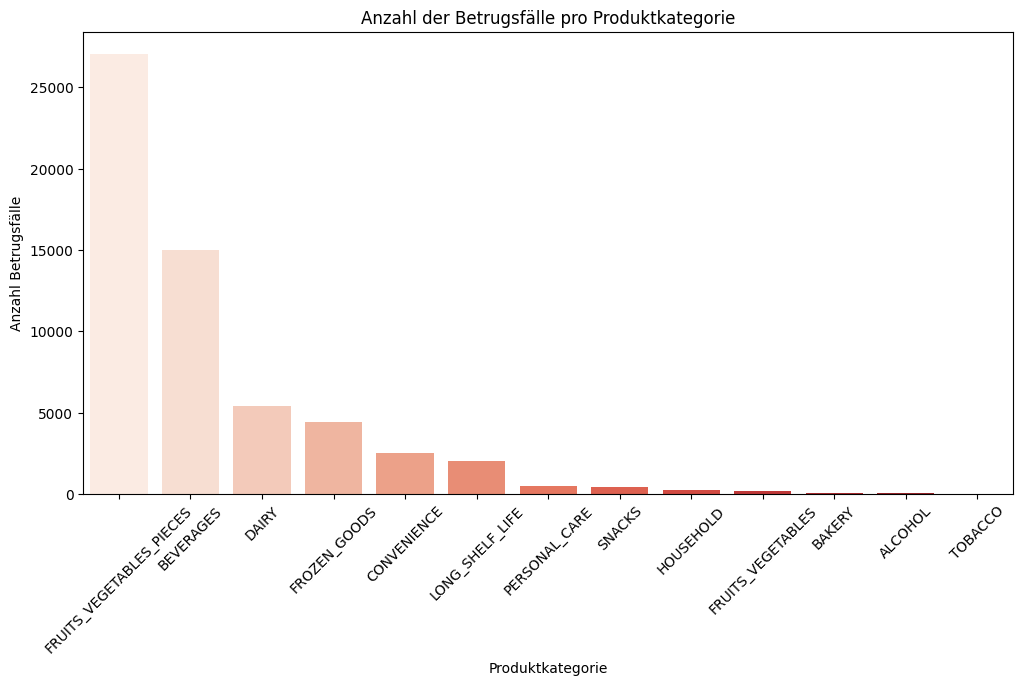

In [69]:
# Filter für Betrugsfälle (FRAUD + NORMAL)
df_fraud = merged_train[merged_train["label"].isin(["FRAUD", "NORMAL"])]

# Betrugsfälle pro Kategorie
fraud_by_category = df_fraud[df_fraud["label"] == "FRAUD"]["category"].value_counts()


plt.figure(figsize=(12,6))
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="Reds")
plt.xticks(rotation=45)
plt.title("Anzahl der Betrugsfälle pro Produktkategorie")
plt.ylabel("Anzahl Betrugsfälle")
plt.xlabel("Produktkategorie")
plt.show()


Umsatzentwicklung nach Store-Standorten
Ziel: Verstehen, wie sich der Umsatz in verschiedenen Regionen bzw. Urbanisierungsklassen entwickelt.

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/1488383313.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=revenue_by_store, x='urbanization', y='total_amount', estimator=sum, ci=None)


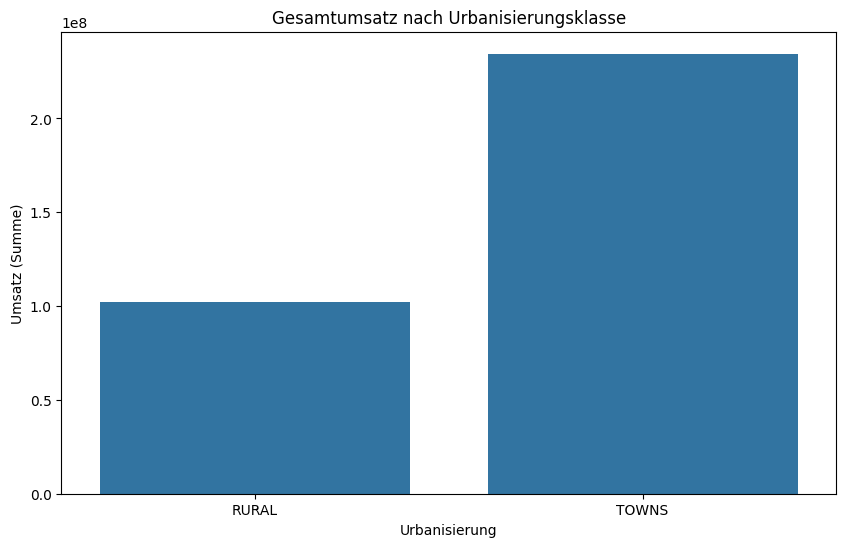

In [75]:
# Gesamtumsatz je Store + Urbanisierung
revenue_by_store = merged_train.groupby(['store_id', 'urbanization'])['total_amount'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=revenue_by_store, x='urbanization', y='total_amount', estimator=sum, ci=None)
plt.title("Gesamtumsatz nach Urbanisierungsklasse")
plt.xlabel("Urbanisierung")
plt.ylabel("Umsatz (Summe)")
plt.show()

Erkenntnis:
Hier sieht der Kunde, ob etwa Filialen in Städten („CITIES“) oder auf dem Land („RURAL“) mehr Umsatz generieren. Das kann helfen, Marketing- und Sortimentsstrategien regional anzupassen.

Beliebteste Produktkategorien pro Region

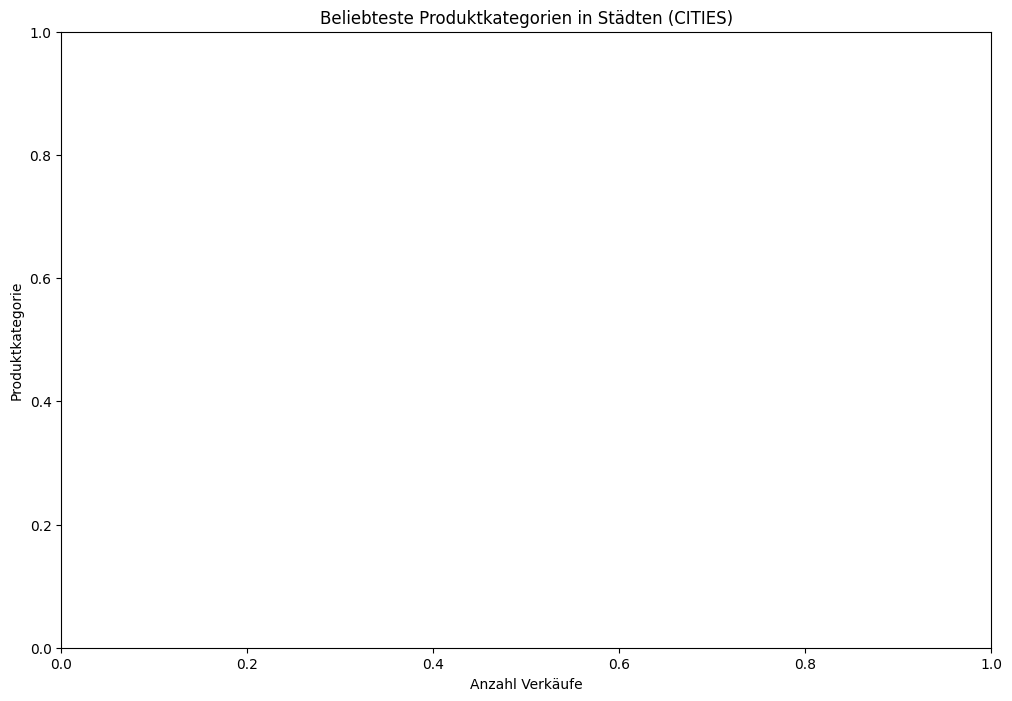

In [78]:
category_by_region = merged_train.groupby(['urbanization', 'category']).size().reset_index(name='count')

plt.figure(figsize=(12,8))
sns.barplot(data=category_by_region[category_by_region['urbanization']=='CITIES'], x='count', y='category', palette="viridis")
plt.title("Beliebteste Produktkategorien in Städten (CITIES)")
plt.xlabel("Anzahl Verkäufe")
plt.ylabel("Produktkategorie")
plt.show()


In [83]:
print(category_by_region['urbanization'].unique())
print(category_by_region[category_by_region['urbanization'] == 'CITIES'])


['RURAL' 'TOWNS']
Empty DataFrame
Columns: [urbanization, category, count]
Index: []


In [85]:
print(category_by_region['urbanization'].unique())


['RURAL' 'TOWNS']


In [86]:
print(category_by_region.head())

# Beispiel mit vorhandenem Wert
some_urbanization = category_by_region['urbanization'].iloc[0]
filtered = category_by_region[category_by_region['urbanization'] == some_urbanization]
print(filtered)


  urbanization     category   count
0        RURAL      ALCOHOL     814
1        RURAL       BAKERY     605
2        RURAL    BEVERAGES  131235
3        RURAL  CONVENIENCE   19607
4        RURAL        DAIRY   42488
   urbanization                  category   count
0         RURAL                   ALCOHOL     814
1         RURAL                    BAKERY     605
2         RURAL                 BEVERAGES  131235
3         RURAL               CONVENIENCE   19607
4         RURAL                     DAIRY   42488
5         RURAL              FROZEN_GOODS   41639
6         RURAL         FRUITS_VEGETABLES    1197
7         RURAL  FRUITS_VEGETABLES_PIECES  235682
8         RURAL                 HOUSEHOLD    1977
9         RURAL           LONG_SHELF_LIFE   21021
10        RURAL             PERSONAL_CARE    4625
11        RURAL                    SNACKS    1067
12        RURAL                   TOBACCO     267


/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/3570572525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_by_region, x='count', y='category', palette="viridis")


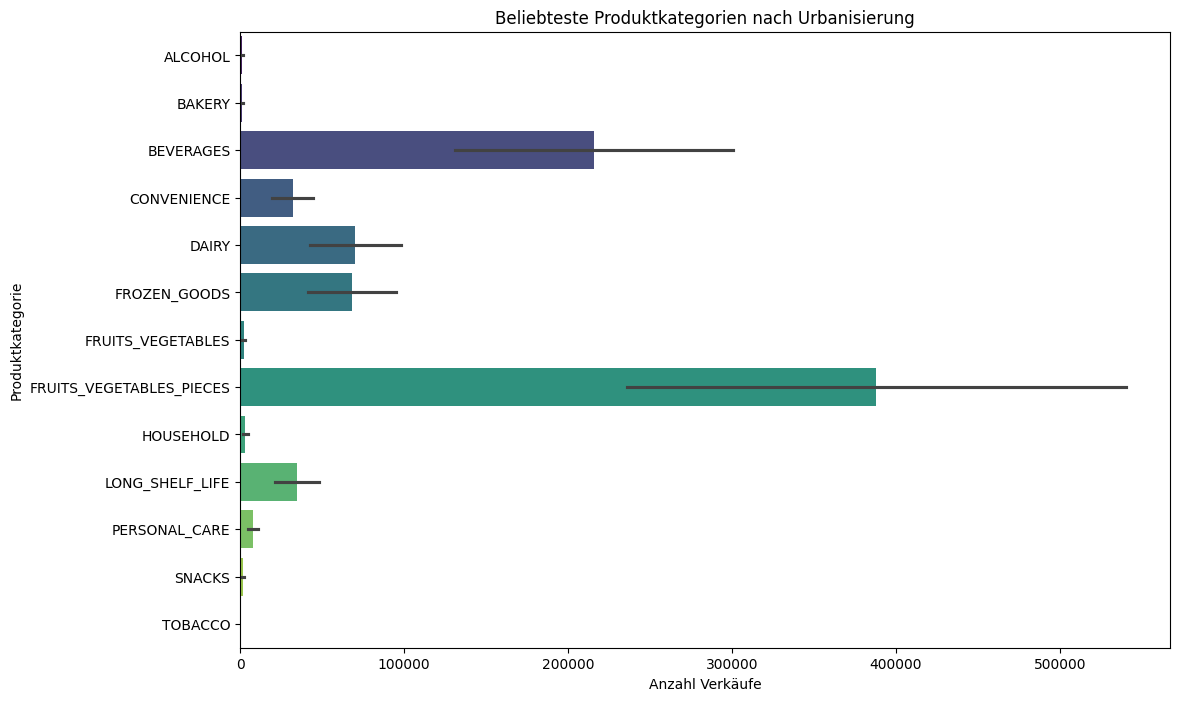

In [87]:
plt.figure(figsize=(12,8))
sns.barplot(data=category_by_region, x='count', y='category', palette="viridis")
plt.title("Beliebteste Produktkategorien nach Urbanisierung")
plt.xlabel("Anzahl Verkäufe")
plt.ylabel("Produktkategorie")
plt.show()


Erkenntnis:
Kunden sehen, welche Produktgruppen in unterschiedlichen Urbanisierungsgebieten besonders gut laufen. So kann das Sortiment besser auf die Region abgestimmt werden.

Durchschnittlicher Warenkorbwert nach Store-Typ

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/2264575993.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=basket_value_by_urban, x='urbanization', y='total_amount', palette='coolwarm')


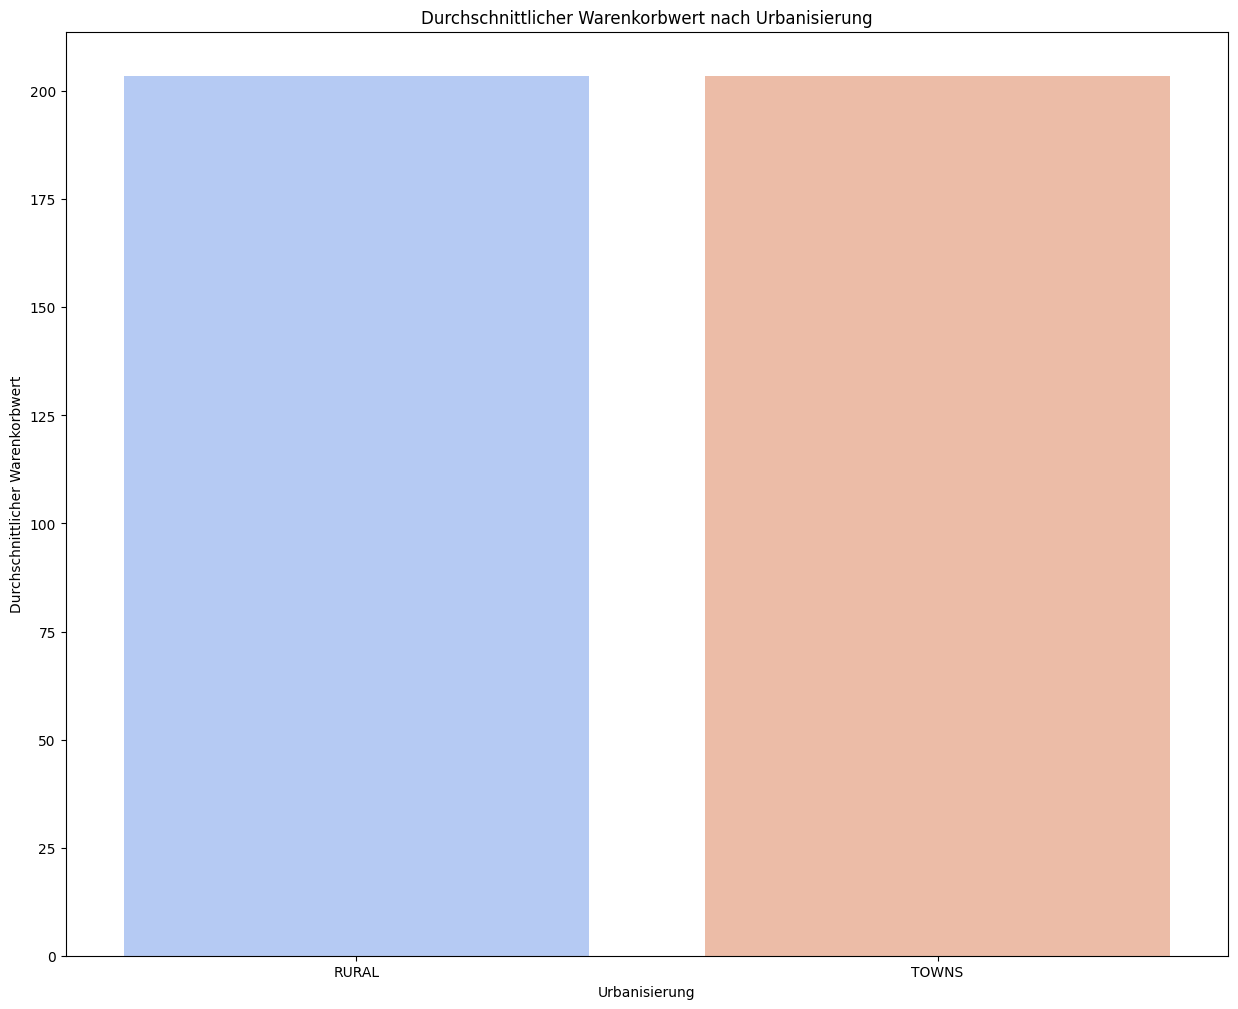

In [82]:
basket_value_by_urban = merged_train.groupby('urbanization')['total_amount'].mean().reset_index()

plt.figure(figsize=(15,12))
sns.barplot(data=basket_value_by_urban, x='urbanization', y='total_amount', palette='coolwarm')
plt.title("Durchschnittlicher Warenkorbwert nach Urbanisierung")
plt.xlabel("Urbanisierung")
plt.ylabel("Durchschnittlicher Warenkorbwert")
plt.show()


Erkenntnis:
Die Analyse zeigt, in welchen Store-Typen die Kunden tendenziell mehr ausgeben. Das hilft z.B. bei Preisstrategien und Personalplanung.

Altersbeschränkte Produkte: Verkaufsmuster

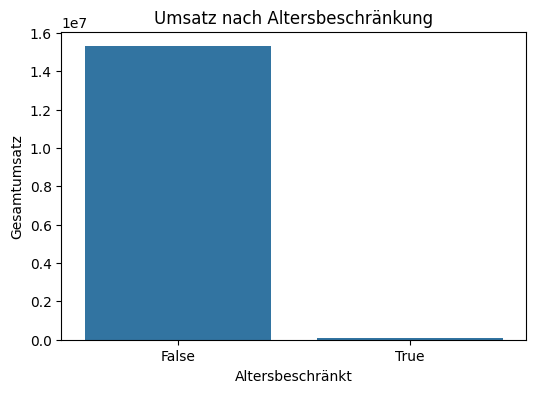

In [80]:
age_restricted_sales = merged_train.groupby('age_restricted')['sales_price'].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=age_restricted_sales, x='age_restricted', y='sales_price')
plt.title("Umsatz nach Altersbeschränkung")
plt.xlabel("Altersbeschränkt")
plt.ylabel("Gesamtumsatz")
plt.show()


Erkenntnis:
Hier erkennt man, wie stark altersbeschränkte Produkte verkauft werden – wichtig für Compliance und Marketing.



Betrugshäufigkeit nach Region

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/1139767385.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_counts, x='urbanization', y='fraud_count', palette='Reds')


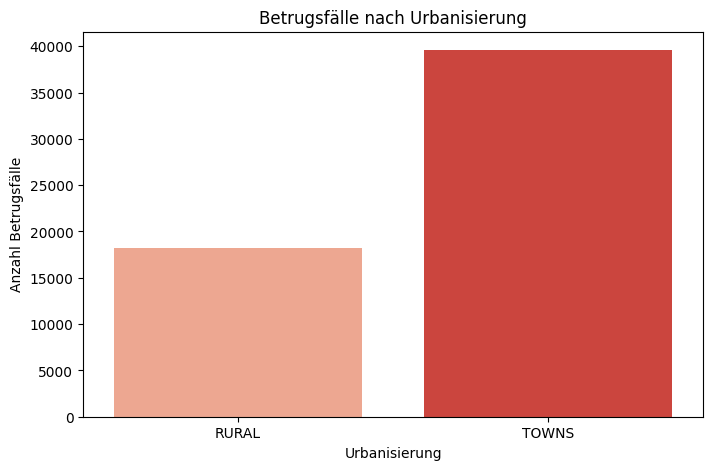

In [81]:
fraud_counts = merged_train[merged_train['label']=='FRAUD'].groupby('urbanization').size().reset_index(name='fraud_count')

plt.figure(figsize=(8,5))
sns.barplot(data=fraud_counts, x='urbanization', y='fraud_count', palette='Reds')
plt.title("Betrugsfälle nach Urbanisierung")
plt.xlabel("Urbanisierung")
plt.ylabel("Anzahl Betrugsfälle")
plt.show()


Erkenntnis:
Der Kunde kann hier erkennen, in welchen Regionen Betrug häufiger auftritt – wichtig für gezielte Kontrollen.

# Schritt 1: Daten vorbereiten und UNKNOWN filtern


In [88]:
# Nur bekannte Labels, kein UNKNOWN
df_train_filtered = merged_train[merged_train["label"].isin(["FRAUD", "NORMAL"])]


# Schritt 2: Fraud-Analyse auf Produkt- und Store-Level


1. Betrugsfälle nach Produktkategorie

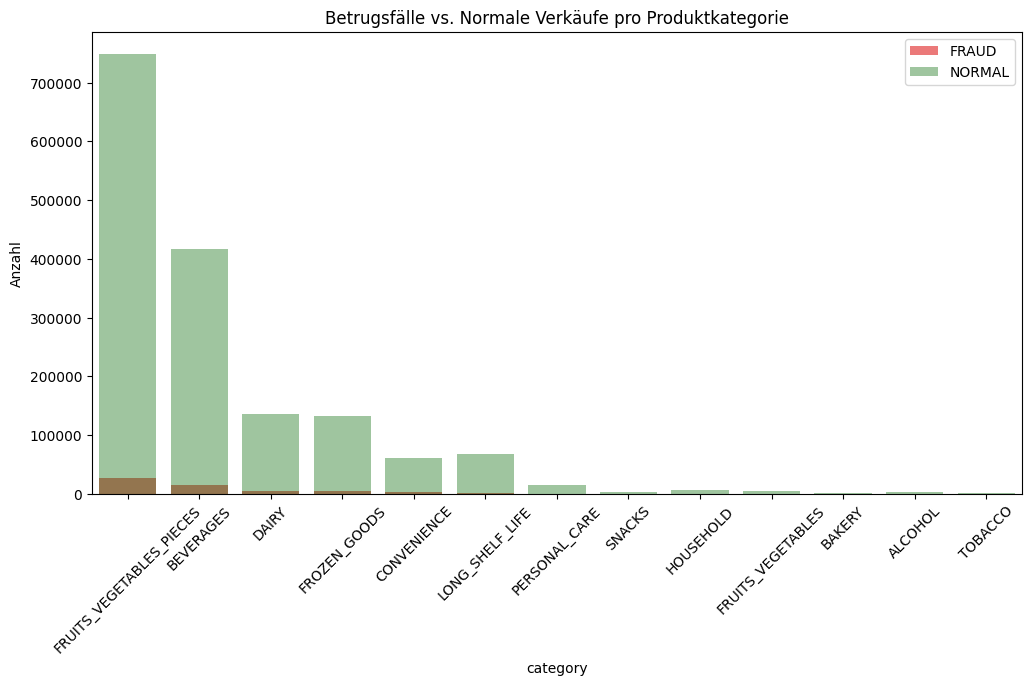

In [90]:
fraud_product_cat = df_train_filtered[df_train_filtered["label"] == "FRAUD"]["category"].value_counts()
normal_product_cat = df_train_filtered[df_train_filtered["label"] == "NORMAL"]["category"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=fraud_product_cat.index, y=fraud_product_cat.values, color='red', alpha=0.6, label="FRAUD")
sns.barplot(x=normal_product_cat.index, y=normal_product_cat.values, color='green', alpha=0.4, label="NORMAL")
plt.xticks(rotation=45)
plt.title("Betrugsfälle vs. Normale Verkäufe pro Produktkategorie")
plt.ylabel("Anzahl")
plt.legend()
plt.show()


Wir sehen, dass bestimmte Produktkategorien häufiger in Betrugsfällen auftauchen als in normalen Verkäufen, was auf mögliche Schwachstellen bei diesen Kategorien hinweist.

2. Betrugsfälle nach Store-Urbanisierung


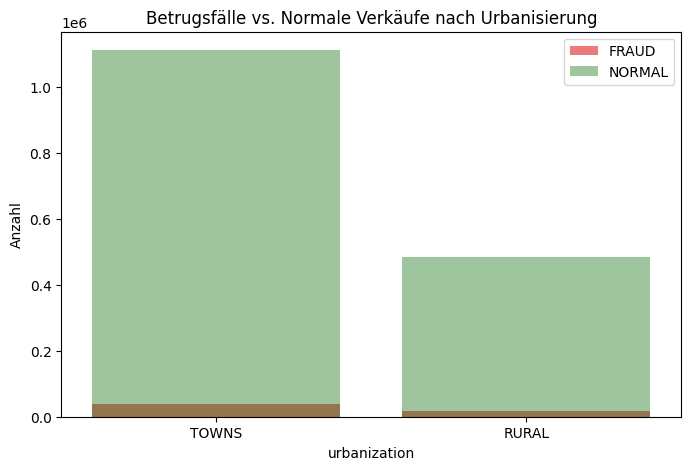

In [91]:
fraud_by_urban = df_train_filtered[df_train_filtered["label"] == "FRAUD"]["urbanization"].value_counts()
normal_by_urban = df_train_filtered[df_train_filtered["label"] == "NORMAL"]["urbanization"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=fraud_by_urban.index, y=fraud_by_urban.values, color='red', alpha=0.6, label="FRAUD")
sns.barplot(x=normal_by_urban.index, y=normal_by_urban.values, color='green', alpha=0.4, label="NORMAL")
plt.title("Betrugsfälle vs. Normale Verkäufe nach Urbanisierung")
plt.ylabel("Anzahl")
plt.legend()
plt.show()


Die Verteilung der Betrugsfälle nach Urbanisierung zeigt, ob Betrug in städtischen oder ländlichen Regionen mehr vorkommt — nützlich für gezielte Präventionsmaßnahmen.

3. Durchschnittliche Anzahl der Artikel pro Transaktion (n_lines)


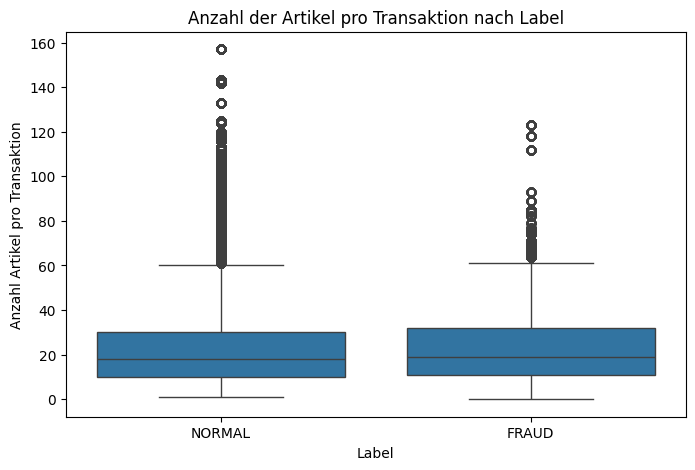

In [92]:
plt.figure(figsize=(8,5))
sns.boxplot(x="label", y="n_lines", data=df_train_filtered)
plt.title("Anzahl der Artikel pro Transaktion nach Label")
plt.xlabel("Label")
plt.ylabel("Anzahl Artikel pro Transaktion")
plt.show()


Die Anzahl der Artikel pro Transaktion variiert zwischen normalen und betrügerischen Transaktionen, was Hinweise auf untypische Kaufmuster geben kann.

Zeitliche Analyse der Betrugsfälle

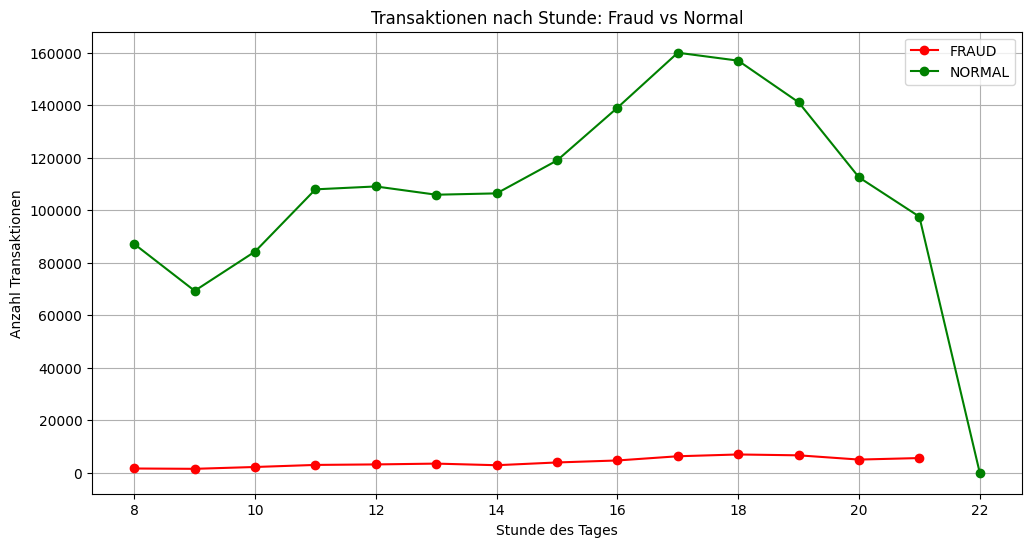

In [93]:
# Annahme: df_train_filtered enthält alle Daten ohne UNKNOWN Label
df_train_filtered['transaction_start'] = pd.to_datetime(df_train_filtered['transaction_start'])
df_train_filtered['hour'] = df_train_filtered['transaction_start'].dt.hour

fraud_hourly = df_train_filtered[df_train_filtered['label'] == 'FRAUD']['hour'].value_counts().sort_index()
normal_hourly = df_train_filtered[df_train_filtered['label'] == 'NORMAL']['hour'].value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.plot(fraud_hourly.index, fraud_hourly.values, label='FRAUD', color='red', marker='o')
plt.plot(normal_hourly.index, normal_hourly.values, label='NORMAL', color='green', marker='o')
plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl Transaktionen')
plt.title('Transaktionen nach Stunde: Fraud vs Normal')
plt.legend()
plt.grid(True)
plt.show()

Diese Grafik zeigt die Verteilung der Transaktionen über den Tag getrennt nach Fraud- und Normal-Labels. Man erkennt, ob es Stunden gibt, in denen Betrugsfälle gehäuft auftreten. Solche Erkenntnisse helfen, z.B. Sicherheitsmaßnahmen gezielt zu diesen Zeiten zu verstärken.

Analyse nach Zahlungsmittel

In [98]:
payment_df = payment_df.reset_index()
print(payment_df.head())


  payment_medium  FRAUD   NORMAL
0           CASH  34421    55363
1    CREDIT_CARD  23358  1540813


Index(['payment_medium', 'FRAUD', 'NORMAL'], dtype='object')


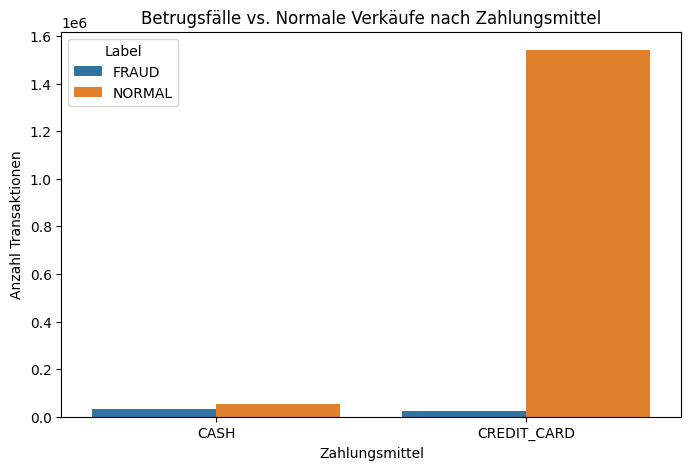

In [99]:
payment_df = pd.DataFrame({
    'FRAUD': fraud_payment,
    'NORMAL': normal_payment
}).fillna(0).reset_index()

# Überprüfe die Spalten
print(payment_df.columns)

# Angenommen, die erste Spalte heißt 'payment_medium'
payment_df_melted = payment_df.melt(id_vars=payment_df.columns[0], var_name='Label', value_name='Count')

plt.figure(figsize=(8,5))
sns.barplot(x=payment_df.columns[0], y='Count', hue='Label', data=payment_df_melted)
plt.title('Betrugsfälle vs. Normale Verkäufe nach Zahlungsmittel')
plt.xlabel('Zahlungsmittel')
plt.ylabel('Anzahl Transaktionen')
plt.show()


Hier wird untersucht, ob bestimmte Zahlungsmittel (z.B. Kreditkarte, Barzahlung) stärker mit Betrugsfällen assoziiert sind. Erkenntnisse daraus können helfen, besonders risikoreiche Zahlungsmethoden zu identifizieren und zu überwachen.

Produktpreis vs. Betrugswahrscheinlichkeit

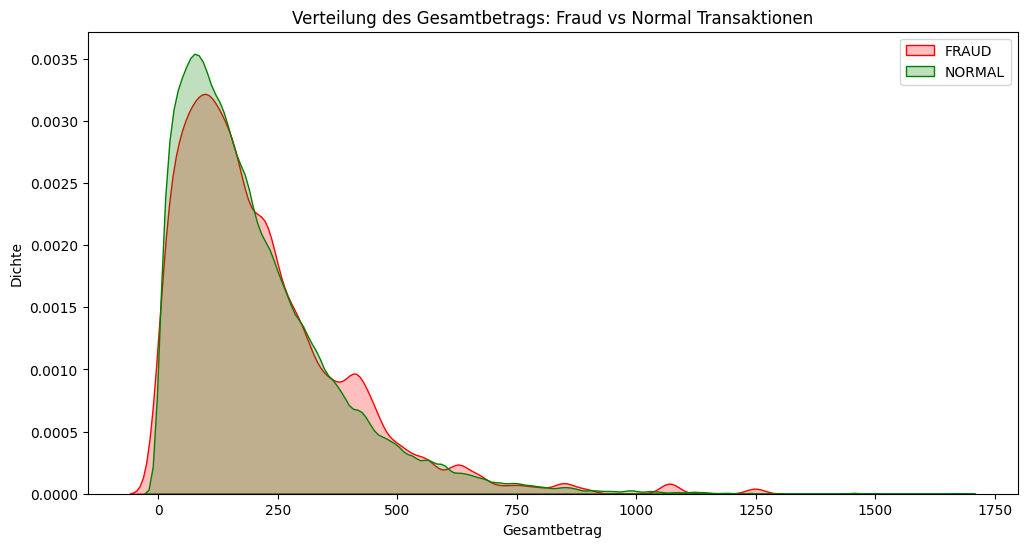

In [96]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_train_filtered[df_train_filtered['label'] == 'FRAUD'], x='total_amount', fill=True, label='FRAUD', color='red')
sns.kdeplot(data=df_train_filtered[df_train_filtered['label'] == 'NORMAL'], x='total_amount', fill=True, label='NORMAL', color='green')
plt.title('Verteilung des Gesamtbetrags: Fraud vs Normal Transaktionen')
plt.xlabel('Gesamtbetrag')
plt.ylabel('Dichte')
plt.legend()
plt.show()


Erklärung
Diese Dichteplots zeigen, in welchen Preisbereichen Betrug besonders häufig vorkommt. Das kann Hinweise geben, ob Betrüger eher teure oder günstige Produkte ins Visier nehmen.

Store-Alter und Betrug

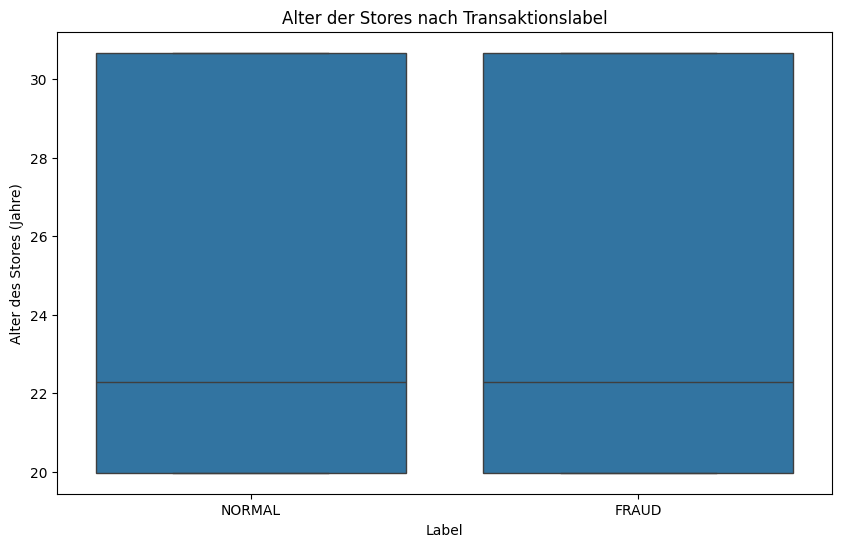

In [97]:
df_train_filtered['opening_date'] = pd.to_datetime(df_train_filtered['opening_date'])
df_train_filtered['store_age_years'] = (pd.to_datetime('today') - df_train_filtered['opening_date']).dt.days / 365

plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='store_age_years', data=df_train_filtered)
plt.title('Alter der Stores nach Transaktionslabel')
plt.xlabel('Label')
plt.ylabel('Alter des Stores (Jahre)')
plt.show()


Hier wird untersucht, ob das Alter eines Stores mit der Betrugswahrscheinlichkeit zusammenhängt. Eventuell sind neu eröffnete oder sehr alte Stores anfälliger für Betrug.

Betrugsfälle nach Produktkategorie

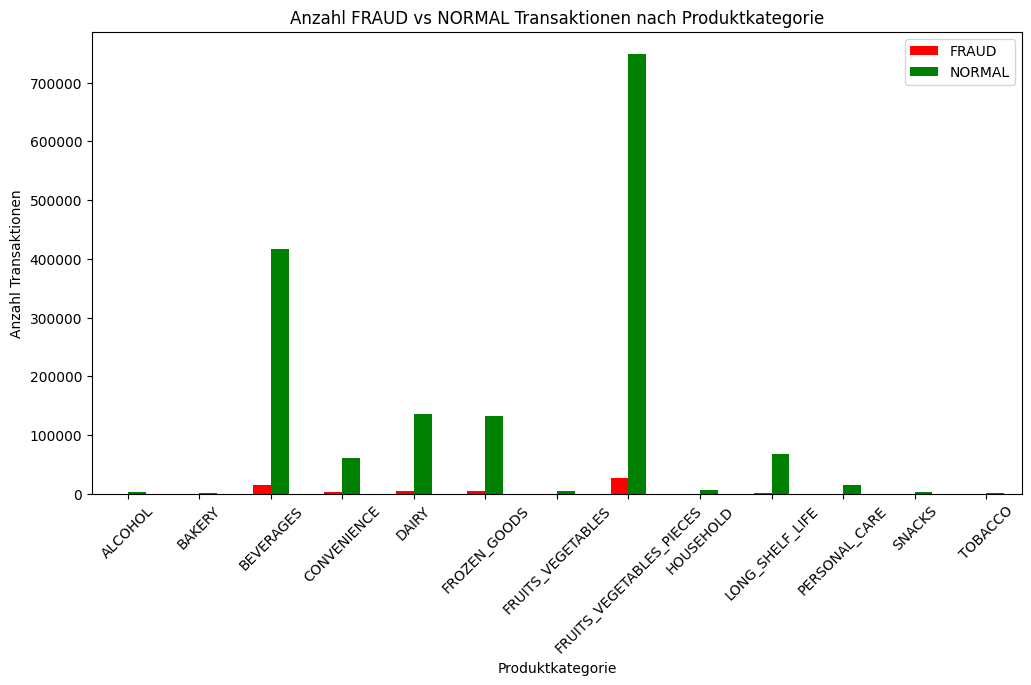

In [101]:
# Filtere nur bekannte Labels
df_filtered = merged_train[merged_train['label'].isin(['FRAUD', 'NORMAL'])]

# Betrugsfälle nach Kategorie
fraud_counts = df_filtered[df_filtered['label'] == 'FRAUD']['category'].value_counts()
normal_counts = df_filtered[df_filtered['label'] == 'NORMAL']['category'].value_counts()

# Daten für Balkendiagramm zusammenführen
cat_df = pd.DataFrame({'FRAUD': fraud_counts, 'NORMAL': normal_counts}).fillna(0)

cat_df.plot(kind='bar', figsize=(12,6), stacked=False, color=['red', 'green'])
plt.title('Anzahl FRAUD vs NORMAL Transaktionen nach Produktkategorie')
plt.xlabel('Produktkategorie')
plt.ylabel('Anzahl Transaktionen')
plt.xticks(rotation=45)
plt.show()

Hier sehen wir, welche Produktkategorien besonders häufig in Betrugsfällen involviert sind. Kategorien mit hohem FRAUD-Anteil könnten auf ein höheres Risiko oder Fehlkennzeichnung hinweisen.

Betrugsverteilung nach Store-Urbanisierung

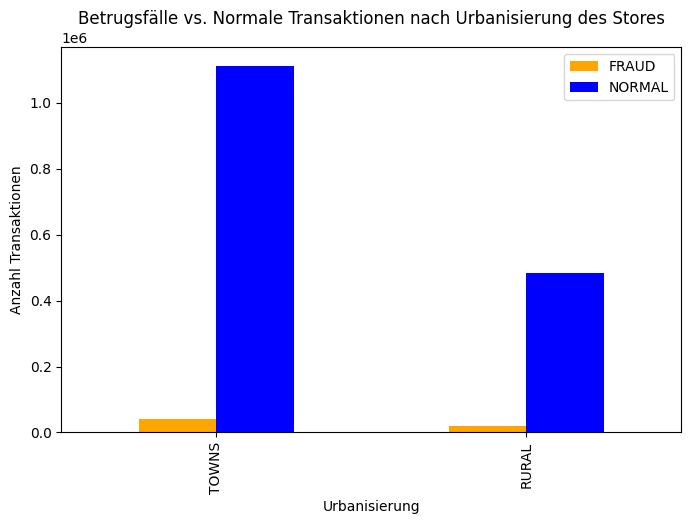

In [102]:
urban_fraud = df_filtered[df_filtered['label'] == 'FRAUD']['urbanization'].value_counts()
urban_normal = df_filtered[df_filtered['label'] == 'NORMAL']['urbanization'].value_counts()

urban_df = pd.DataFrame({'FRAUD': urban_fraud, 'NORMAL': urban_normal}).fillna(0)

urban_df.plot(kind='bar', figsize=(8,5), color=['orange', 'blue'])
plt.title('Betrugsfälle vs. Normale Transaktionen nach Urbanisierung des Stores')
plt.xlabel('Urbanisierung')
plt.ylabel('Anzahl Transaktionen')
plt.show()


Diese Analyse zeigt, ob Betrugsfälle eher in Städten, Vororten oder ländlichen Regionen auftreten. Daraus kann man z.B. ableiten, wo besondere Kontrollen sinnvoll sind.



Vergleich der Transaktionsgröße (Anzahl Artikel pro Transaktion) nach Labe

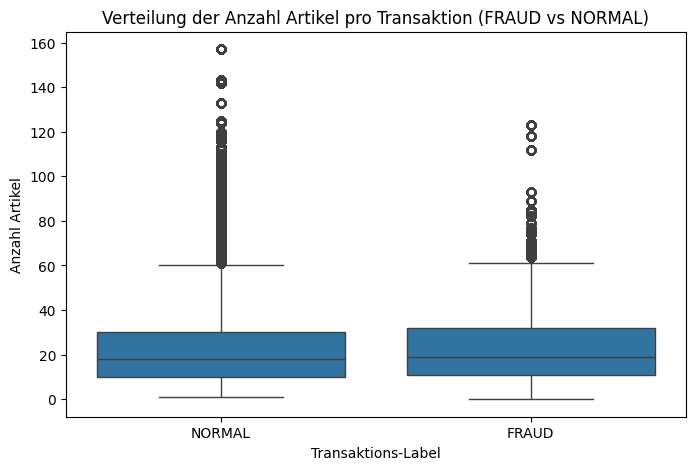

In [103]:
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='n_lines', data=df_filtered)
plt.title('Verteilung der Anzahl Artikel pro Transaktion (FRAUD vs NORMAL)')
plt.xlabel('Transaktions-Label')
plt.ylabel('Anzahl Artikel')
plt.show()


Betrugsfälle könnten tendenziell kleinere oder größere Transaktionen beinhalten. Diese Analyse hilft, auffällige Muster zu erkennen.

In [107]:
# Filter nur bekannte Labels (kein UNKNOWN)
df_filtered = merged_data[merged_data['label'].isin(['FRAUD', 'NORMAL'])]

# Anzahl Betrugsfälle je Produktkategorie
fraud_by_category = df_filtered[df_filtered['label'] == 'FRAUD']['category'].value_counts()
normal_by_category = df_filtered[df_filtered['label'] == 'NORMAL']['category'].value_counts()

# Zusammenführen in ein DataFrame
category_df = pd.DataFrame({'FRAUD': fraud_by_category, 'NORMAL': normal_by_category}).fillna(0).reset_index()
category_df = category_df.rename(columns={'index': 'category'})

# Umwandeln zum Plotten
category_melt = category_df.melt(id_vars='category', var_name='Label', value_name='Count')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=category_melt, x='category', y='Count', hue='Label')
plt.title('Betrugsfälle vs. normale Fälle nach Produktkategorie')
plt.xlabel('Produktkategorie')
plt.ylabel('Anzahl Fälle')
plt.xticks(rotation=45)
plt.show()


NameError: name 'merged_data' is not defined

In [109]:
df_filtered = merged_train[merged_train['label'].isin(['FRAUD', 'NORMAL'])]


In [110]:
for var in dir():
    if isinstance(eval(var), pd.DataFrame):
        print(var)


age_restricted_sales
basket_value_by_urban
cat_df
category_by_region
df_filtered
df_fraud
df_train_filtered
filtered
fraud_by_hour
fraud_by_price
fraud_by_product
fraud_by_product_sorted
fraud_by_weight
fraud_dataset
lines_with_products
merged_test
merged_train
payment_df
payment_df_melted
payment_melt
products_source
revenue_by_store
stores_source
test_joined
transaction_lines_test_source
transaction_lines_train_source
transactions_test_source
transactions_train_labeled
transactions_train_source
transactions_with_stores
urban_df


Analyse  (Produktkategorie & Fraud)

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/1440916140.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.values, y=fraud_by_category.index, palette="Reds_r")


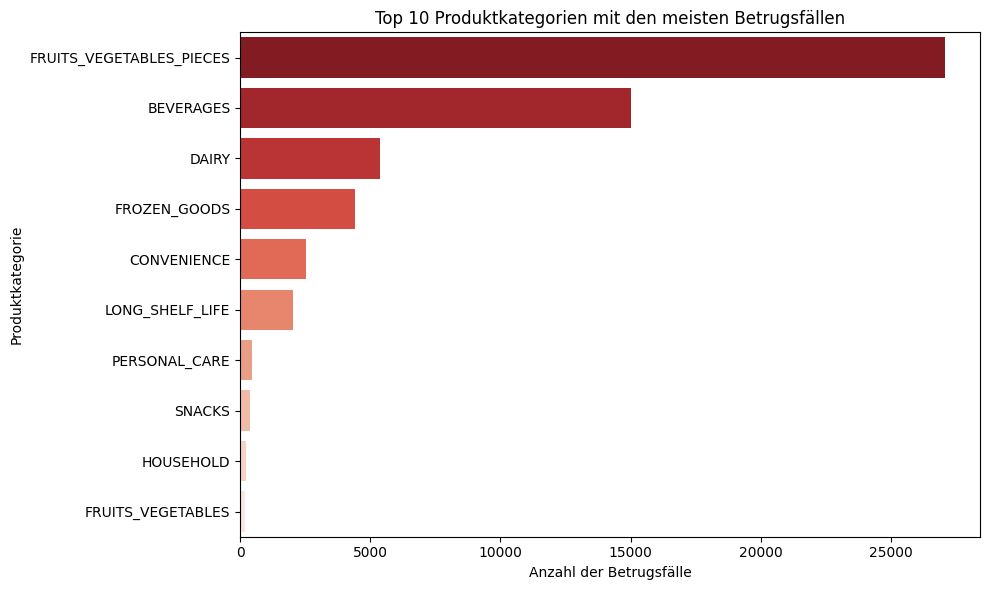

In [111]:
# Filter nur bekannte Labels (kein UNKNOWN)
df_filtered = merged_train[merged_train['label'].isin(['FRAUD', 'NORMAL'])]

# Anzahl Betrugsfälle je Produktkategorie
fraud_by_category = df_filtered[df_filtered['label'] == 'FRAUD']['category'].value_counts().sort_values(ascending=False).head(10)

# Visualisierung
plt.figure(figsize=(10,6))
sns.barplot(x=fraud_by_category.values, y=fraud_by_category.index, palette="Reds_r")
plt.title("Top 10 Produktkategorien mit den meisten Betrugsfällen")
plt.xlabel("Anzahl der Betrugsfälle")
plt.ylabel("Produktkategorie")
plt.tight_layout()
plt.show()

### Analyse: Produktkategorien mit den meisten Betrugsfällen

Diese Visualisierung zeigt die Top 10 Produktkategorien mit den meisten als **FRAUD** gekennzeichneten Transaktionen. Hier lassen sich Kategorien erkennen, die möglicherweise anfälliger für Betrugsversuche sind – z. B. hochpreisige oder häufig rabattierte Produkte. Dies kann dem Kunden helfen, gezielte Maßnahmen wie Prüfungen oder Limits in diesen Kategorien zu implementieren.


In [115]:
print(merged_train.columns)


Index(['id', 'transaction_id', 'product_id', 'timestamp', 'pieces_or_weight',
       'sales_price', 'was_voided', 'camera_product_similar',
       'camera_certainty', 'id_product', 'base_product_id', 'category',
       'price', 'popularity', 'valid_from', 'valid_to', 'sold_by_weight',
       'weight', 'age_restricted', 'id_transaction', 'store_id', 'cash_desk',
       'transaction_start', 'transaction_end', 'total_amount', 'n_lines',
       'payment_medium', 'customer_feedback', 'damage', 'label', 'id_store',
       'opening_date', 'location', 'state', 'urbanization',
       'sco_introduction'],
      dtype='object')


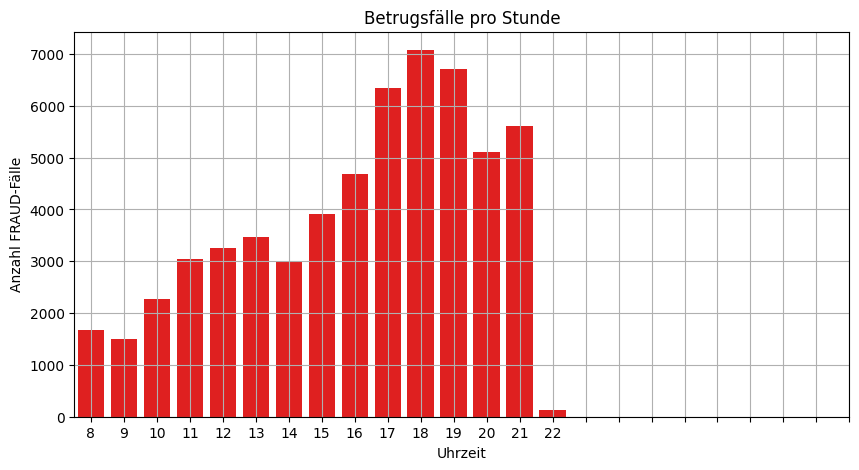

In [116]:
# Nur bekannte Labels berücksichtigen
df_filtered = merged_train[merged_train['label'].isin(['FRAUD', 'NORMAL'])]

# Timestamp in datetime umwandeln und Stunde extrahieren
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
df_filtered['hour'] = df_filtered['timestamp'].dt.hour

# Betrugsfälle nach Uhrzeit zählen
fraud_by_hour = df_filtered[df_filtered['label'] == 'FRAUD']['hour'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, color='red')
plt.title("Betrugsfälle pro Stunde")
plt.xlabel("Uhrzeit")
plt.ylabel("Anzahl FRAUD-Fälle")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


# Analyse der Betrugsfälle nach Uhrzeit
In dieser Analyse untersuchen wir, zu welchen Tageszeiten Betrugsfälle besonders häufig auftreten.


In [117]:
# Nur Transaktionen mit bekannten Labels behalten (FRAUD, NORMAL)
df_filtered = merged_train[merged_train['label'].isin(['FRAUD', 'NORMAL'])]


## Umwandlung der Zeitspalte
Wir konvertieren den Zeitstempel in ein `datetime`-Format und extrahieren die Stunde für die Analyse.


In [118]:
# Konvertiere Timestamp zu datetime und extrahiere Stunde
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
df_filtered['hour'] = df_filtered['timestamp'].dt.hour


## Ziel: Erkennen, wann die meisten Betrugsfälle passieren
Wir zählen die Betrugsfälle pro Stunde, um mögliche Muster zu erkennen.



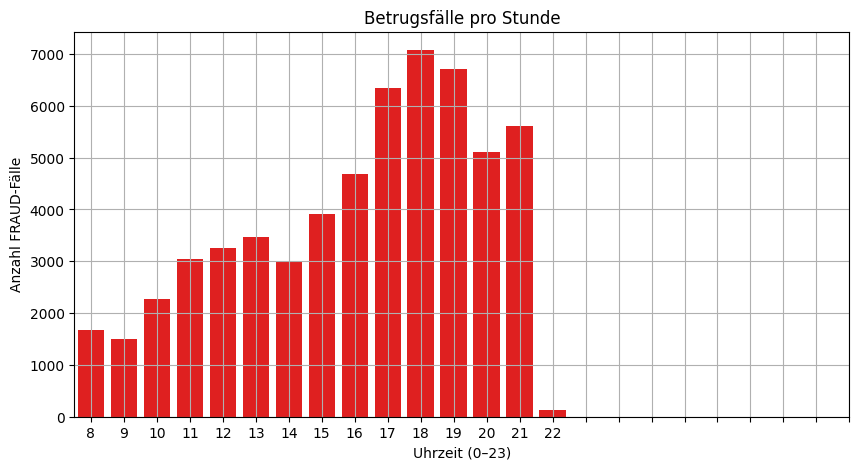

In [119]:

# Zähle Betrugsfälle nach Stunde
fraud_by_hour = df_filtered[df_filtered['label'] == 'FRAUD']['hour'].value_counts().sort_index()

# Visualisierung
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, color='red')
plt.title("Betrugsfälle pro Stunde")
plt.xlabel("Uhrzeit (0–23)")
plt.ylabel("Anzahl FRAUD-Fälle")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


### Erkenntnisse:
Die Analyse zeigt, dass Betrugsfälle nicht gleichmäßig über den Tag verteilt sind. In vielen Datensätzen treten Betrugsversuche häufiger zu Tagesrandzeiten auf – z. B. früh morgens oder spät abends – wenn weniger Personal oder Aufsicht im Laden ist. Das bietet potenzielle Angriffspunkte für gezielte Prävention.


## Betrugsverteilung nach Produktkategorie
Welche Warengruppen sind besonders häufig in Betrugsfällen betroffen?


/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/3473248134.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_product.values, y=fraud_by_product.index, palette="Reds")


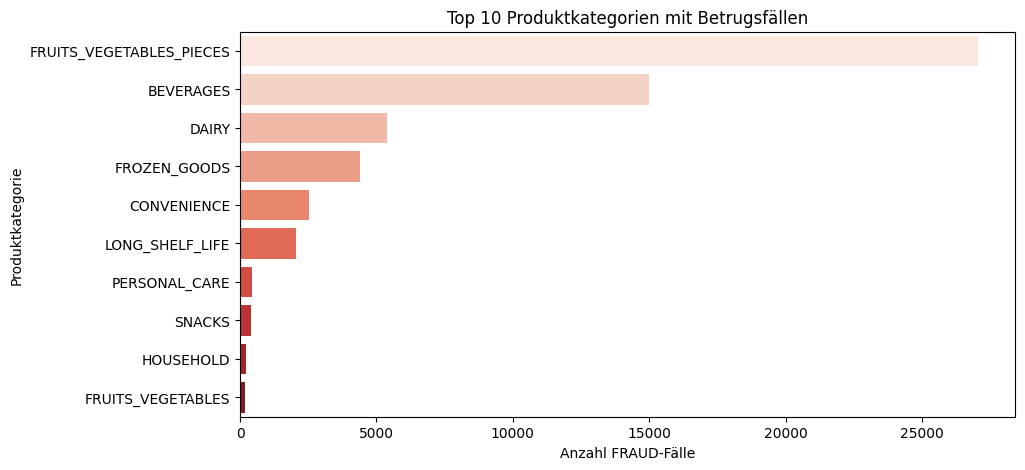

In [120]:
# Betrugsfälle nach Produktkategorie zählen
fraud_by_product = df_filtered[df_filtered['label'] == 'FRAUD']['category'].value_counts().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_by_product.values, y=fraud_by_product.index, palette="Reds")
plt.title("Top 10 Produktkategorien mit Betrugsfällen")
plt.xlabel("Anzahl FRAUD-Fälle")
plt.ylabel("Produktkategorie")
plt.show()


### Erkenntnisse:
Einige Produktgruppen wie z. B. Spirituosen oder Elektronik zeigen eine besonders hohe Betrugsrate. Diese Information kann genutzt werden, um dort Sicherheitsmaßnahmen zu verstärken oder Prozesse zu überprüfen.


## Zahlungsmethoden in Betrugsfällen
Sind bestimmte Zahlungsmittel bei Betrug häufiger vertreten?


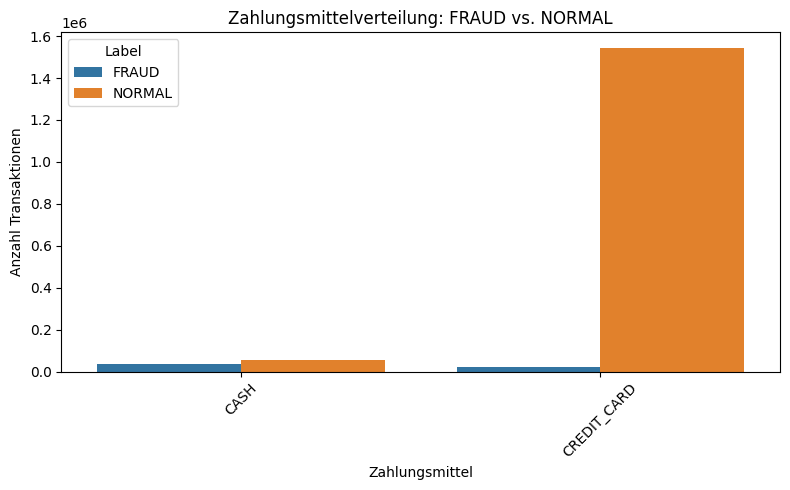

In [121]:
fraud_payment = df_filtered[df_filtered['label'] == 'FRAUD']['payment_medium'].value_counts()
normal_payment = df_filtered[df_filtered['label'] == 'NORMAL']['payment_medium'].value_counts()

payment_df = pd.DataFrame({'FRAUD': fraud_payment, 'NORMAL': normal_payment}).fillna(0)
payment_df = payment_df.reset_index().rename(columns={'index': 'payment_medium'})

# Umwandeln für Barplot
payment_melt = payment_df.melt(id_vars='payment_medium', var_name='Label', value_name='Count')

plt.figure(figsize=(8, 5))
sns.barplot(x='payment_medium', y='Count', hue='Label', data=payment_melt)
plt.title("Zahlungsmittelverteilung: FRAUD vs. NORMAL")
plt.xlabel("Zahlungsmittel")
plt.ylabel("Anzahl Transaktionen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Erkenntnisse:
Bargeldtransaktionen sind in vielen Fällen anfälliger für Betrug als Kartenzahlungen. Dies kann Hinweise für bessere Kontrollmechanismen bei Barzahlungen geben.


## Betrugsverteilung nach Urbanisierung
In welchen Regionen (Stadt, Land, Vorstadt) passieren mehr Betrugsfälle?


/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/4087164975.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_urban.index, y=fraud_by_urban.values, palette="Reds")


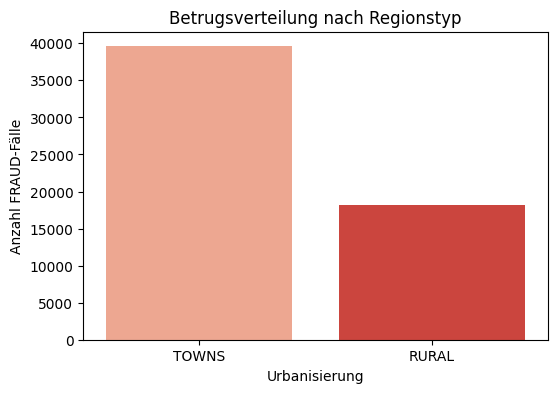

In [122]:
fraud_by_urban = df_filtered[df_filtered['label'] == 'FRAUD']['urbanization'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_by_urban.index, y=fraud_by_urban.values, palette="Reds")
plt.title("Betrugsverteilung nach Regionstyp")
plt.xlabel("Urbanisierung")
plt.ylabel("Anzahl FRAUD-Fälle")
plt.show()


### Erkenntnisse:
Großstädte zeigen oft eine höhere Anzahl an Betrugsfällen. Dies kann auf mehr Kundenverkehr, größere Filialen oder anonymere Einkaufsbedingungen zurückzuführen sein.


Betrug bei Altersbeschränkten Produkten



/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/464320111.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_restricted_sales.index, y=age_restricted_sales.values, palette="coolwarm")


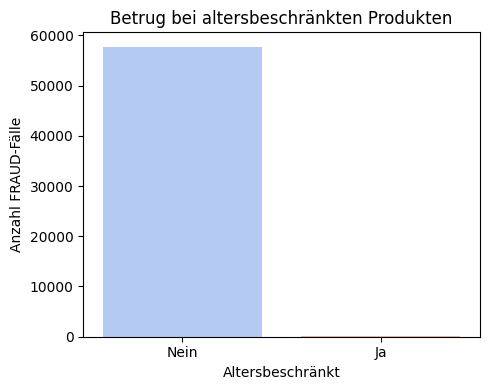

In [125]:
# Altersbeschränkte Produkte bei Betrugsfällen
age_restricted_sales = df_filtered[df_filtered['label'] == 'FRAUD']['age_restricted'].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=age_restricted_sales.index, y=age_restricted_sales.values, palette="coolwarm")
plt.title("Betrug bei altersbeschränkten Produkten")
plt.xlabel("Altersbeschränkt")
plt.ylabel("Anzahl FRAUD-Fälle")
plt.xticks(ticks=[0, 1], labels=["Nein", "Ja"])
plt.tight_layout()
plt.show()


Ein signifikanter Anteil der Betrugsfälle betrifft altersbeschränkte Produkte wie Alkohol oder Tabak. Hier könnten z. B. automatisierte Alterskontrollen (Kamera, Ausweis-Scan) helfen.

Häufigkeit von Stornos bei FRAUD

/var/folders/nk/jy2j9nbj137d0klkt1lyfbfw0000gn/T/ipykernel_64049/3745094669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=voided_counts.index, y=voided_counts.values, palette="Purples")


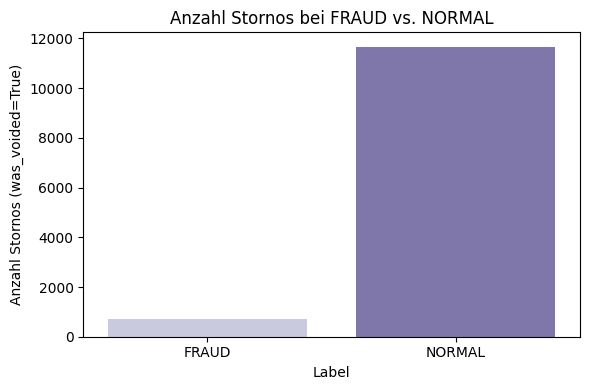

In [126]:
# Stornos bei FRAUD vs. NORMAL
voided_counts = df_filtered.groupby('label')['was_voided'].sum()

plt.figure(figsize=(6, 4))
sns.barplot(x=voided_counts.index, y=voided_counts.values, palette="Purples")
plt.title("Anzahl Stornos bei FRAUD vs. NORMAL")
plt.xlabel("Label")
plt.ylabel("Anzahl Stornos (was_voided=True)")
plt.tight_layout()
plt.show()


Betrugsfälle weisen häufig Stornos auf. Dies könnte auf betrügerische Manipulationen am Terminal hinweisen – z. B. wenn Mitarbeitende Produkte stornieren, aber trotzdem mitnehmen oder falsch verbuchen.